In [1]:
import pandas as pd
import mysql
from connect import DatabaseConnector
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Total Views : from the Vendor Views logs Table We use the vendor_id to count the number views made

In [2]:
def get_vendor_Total_Views(vendor_id): # vendor_id == user_id
    
    db_connector = DatabaseConnector()  # Create an instance of DatabaseConnector
    # Connect to the database
    db_connector.connect_db()
    # Get the database connection
    connection = db_connector.get_connection()

    # If connection is not established, return
    if connection is None:
        print("No connection available to summarize the database.")
        return
    cursor = connection.cursor()

    try:
        # Execute the query to calculate the total count of the specified vendor_id
        query = f"""
            SELECT COUNT(*) AS count
            FROM vendor_view_logs
            WHERE vendor_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract count from the result tuple
        else:
            return 0  # If no rows are found, return count as 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [3]:
get_vendor_Total_Views(26)

Successfully connected to the database
Connection closed


6961

# We can ranke our vendor produt views with the highest views

In [5]:
def plot_vendor_comparison(vendor_id): # vendor_id == user_id
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve vendor counts.")
        return

    cursor = connection.cursor()

    try:
        # Get count for the specified vendor_id and all vendors
        query = """
            SELECT vendor_id, COUNT(*) AS total_views
            FROM vendor_view_logs
            GROUP BY vendor_id
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Create a DataFrame from the results
        df = pd.DataFrame(results, columns=['vendor_id', 'total_views'])

        # Get count for the specified vendor_id
        specified_vendor_count = df[df['vendor_id'] == vendor_id]['total_views'].values[0]

        # Get the vendor_id with the highest count
        highest_vendor_count = df['total_views'].max()

        # Get ranks
        df['rank'] = df['total_views'].rank(method='min', ascending=False)
        specified_vendor_rank = df[df['vendor_id'] == vendor_id]['rank'].values[0]
        highest_vendor_rank = df[df['total_views'] == highest_vendor_count]['rank'].values[0]

        # Plotting
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Specified Vendor', 'Highest Vendor'], [specified_vendor_count, highest_vendor_count], color=['skyblue', 'orange'])
        plt.xlabel('Vendor')
        plt.ylabel('Total Views')
        plt.title('Comparison of Specified Vendor vs Highest Vendor')

        # Add rank numbers at the top of each bar
        plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'Rank: {int(specified_vendor_rank)}', ha='center', va='bottom')
        plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'Rank: {int(highest_vendor_rank)}', ha='center', va='bottom')

        plt.show()
    except mysql.connector.Error as e:
        print(f"Error: {e}")
    finally:
        cursor.close()
        db_connector.close_connection()

Successfully connected to the database


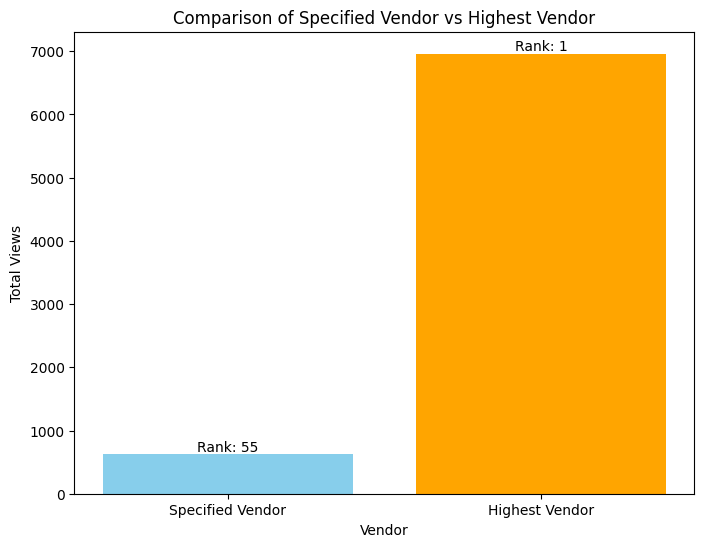

Connection closed


In [6]:
plot_vendor_comparison(268)

In [7]:
def is_vendor(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to check user type.")
        return False

    cursor = connection.cursor()

    try:
        # Query to check if the user is a vendor
        query = """
            SELECT type
            FROM users
            WHERE id = %s
        """
        cursor.execute(query, (user_id,))
        result = cursor.fetchone()

        if result and result[0] == 'vendor':
            return True
        else:
            return False
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return False
    finally:
        cursor.close()
        db_connector.close_connection()


# Example usage
user_id = 123  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 123 a vendor? True


# 2. Unique Customers Count based on the buy_logs, Products, and Vendor table

In [8]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT buy_logs.user_id) AS unique_customers_count
            FROM vendors
            JOIN products ON vendors.user_id = products.user_id
            JOIN buy_logs ON products.id = buy_logs.product_id
            WHERE vendors.user_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [9]:
# Example usage
vendor_id = 26  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 26: 274


# 2.1 Optimized Unique Costomers Count based on the buy_logs, Products, and Vendor table

In [10]:
def get_unique_customers_count(vendor_id): # vendor_id == user_id
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Nested query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT user_id) AS unique_customers_count
            FROM buy_logs
            WHERE product_id IN (
                SELECT id
                FROM products
                WHERE user_id = (
                    SELECT user_id
                    FROM vendors
                    WHERE user_id = %s
                )
            )
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()


In [11]:

# Example usage
vendor_id = 26  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 26: 274


# 3. Number views Per Products  making use of View_product_logs

In [12]:
def get_product_views_count(product_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of views for the given product_id
        query = """
            SELECT COUNT(*) AS views_count
            FROM product_view_logs
            WHERE product_id = %s
        """
        cursor.execute(query, (product_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract views_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [13]:
# Example usage
product_id = 1  # Replace with the actual product ID
views_count = get_product_views_count(product_id)
print(f"Number of views for product ID {product_id}: {views_count}")

Successfully connected to the database
Connection closed
Number of views for product ID 1: 20


# 3.1 Now lets compare the views count for each product callisified under a provided vendor_id: product_view_logs, Vendors, Products

In [14]:
def get_vendor_product_views_and_plot(vendor_id): # vendor_id == user_id
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Step 1: Get all product IDs and names for the given vendor_id
        product_query = """
            SELECT id, name
            FROM products
            WHERE user_id = %s
        """
        cursor.execute(product_query, (vendor_id,))
        products = cursor.fetchall()

        if not products:
            print(f"No products found for vendor_id {vendor_id}")
            return None

        # Convert products to a list of tuples
        product_data = [(product_id, product_name) for product_id, product_name in products]
        product_ids = [product_id for product_id, _ in products]

        # Step 2: Get the count of views for each product_id in the list using a single query
        format_ids = ','.join(map(str, product_ids))
        view_count_query = f"""
            SELECT product_id, COUNT(*) AS product_id_count
            FROM product_view_logs
            WHERE product_id IN ({format_ids})
            GROUP BY product_id
        """
        cursor.execute(view_count_query)
        view_counts = cursor.fetchall()

        # Create a dictionary from the view counts
        view_count_dict = {product_id: count for product_id, count in view_counts}

        # Step 3: Prepare the final data with all product_ids, their names, and their counts
        product_view_counts = [(product_id, product_name, view_count_dict.get(product_id, 0)) for product_id, product_name in product_data]

        # Step 4: Create the DataFrame
        df_vendor_product_views = pd.DataFrame(product_view_counts, columns=['product_id', 'product_name', 'product_id_count'])

        return df_vendor_product_views
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_dataframe(df):
    if df is not None and not df.empty:
        plt.figure(figsize=(14, 8))  # Increase the figure size
        plt.bar(df['product_name'], df['product_id_count'], color='blue')
        plt.xlabel('Product Name')
        plt.ylabel('View Count')
        plt.title(f'Product View Counts')
        plt.xticks(rotation=90)
        
        # Manually adjust the subplot parameters to give more room for the labels
        plt.subplots_adjust(bottom=0.3)  # Adjust the bottom margin
        
        plt.show()
    else:
        print("The DataFrame is empty or None.")

In [15]:
# Example usage
vendor_id = 26  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views_and_plot(vendor_id)
print(df_vendor_product_views)

Successfully connected to the database
Connection closed
     product_id                                       product_name  \
0            39                                           iphone 7   
1            40                                           iphone 7   
2            41                       COUCH, SIDE SOFAS, SOFA SETS   
3            42                                       5 place Sofa   
4            43                                     Titan TV Stand   
..          ...                                                ...   
911       20127                                       MacBook 2019   
912       20128  Porte épices rotatif, sucre, mayonnaise,  poiv...   
913       20129                                       MacBook 2019   
914       20130                                       MacBook 2019   
915       20131  Climatiseur split SIGNATURE - 1,25 CV - 9000 B...   

     product_id_count  
0                2749  
1                4114  
2                2051  
3     

Successfully connected to the database
Connection closed


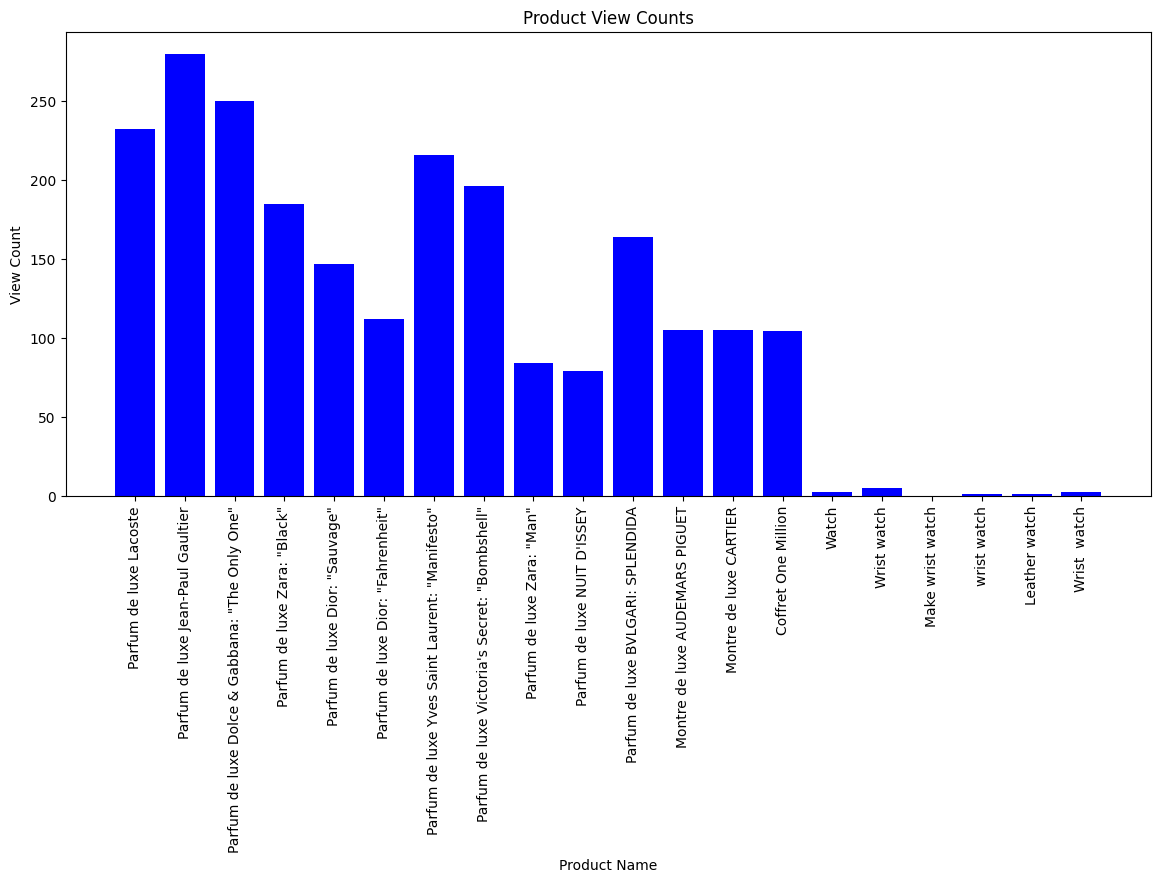

In [16]:
vendor_id = 268  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views_and_plot(vendor_id)
plot_dataframe(df_vendor_product_views)

# 4. Views Per Catigoury

In [8]:
def get_customer_category_views_count(vendor_id):
    
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to summarize the database.")
        return None

    try:
        # Subquery to get all category IDs for the provided vendor_id
        subquery = f"""
        SELECT DISTINCT category_id
        FROM products
        WHERE user_id = (SELECT user_id FROM vendors WHERE user_id = {vendor_id})
        """

        # Main query to count views for each category
        query = f"""
        SELECT c.id AS category_id, c.name AS category_name, 
        (SELECT COUNT(*) FROM category_view_logs cvl WHERE cvl.category_id = c.id) AS views_count
        FROM categories c
        WHERE c.id IN ({subquery})
        """

        df = pd.read_sql(query, connection)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()


# Plote the returned dataframe 

def plot_category_views(df):
    # Get the DataFrame with category view counts
    if df is None or df.empty:
            print("No data available to plot.")
            return

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x='category_name', y='views_count', hue='category_name', data=df, palette='viridis', legend=False)

    # Adding titles and labels
    plt.title('Category Views Count for Vendor')
    plt.xlabel('Category Name')
    plt.ylabel('Views Count')
    
    # Rotate category names for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


In [9]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_customer_category_views_count = get_customer_category_views_count(vendor_id)
print(df_customer_category_views_count)

Successfully connected to the database


/tmp/ipykernel_42939/1030378465.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Connection closed
   category_id       category_name  views_count
0           61        Smart Phones         1598
1           62  Mobile Accessories         2074
2           72            Nintendo          632
3           73                XBOX          299
4           74           Top Games           86
5          193       Playstation 4          788
6          196         Playstation          379
7          307      Accessory Kits          290
8          379      Other Products          447


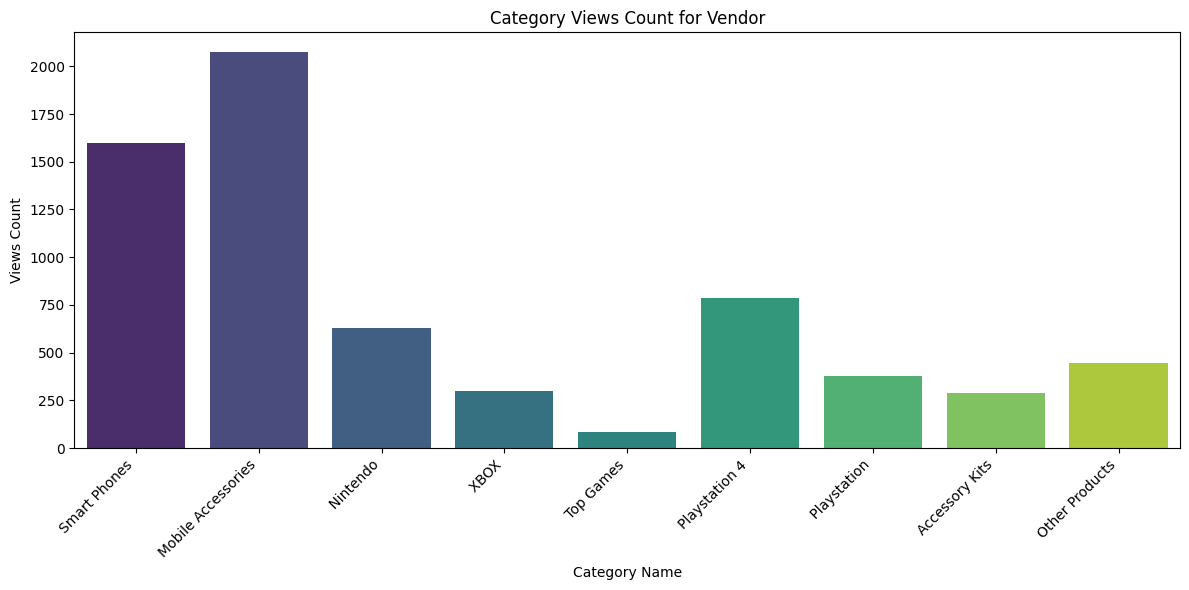

In [10]:
plot_category_views(df_customer_category_views_count)

# 6.Views Per USer

In [2]:
def get_user_view_count(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT COUNT(*) AS view_count
        FROM product_view_logs
        WHERE user_id = %s
        """
        
        # Use SQLAlchemy engine to execute the query
        df = pd.read_sql(query, connection, params=(user_id,))
        
        # Return the view count from the DataFrame
        return df['view_count'].iloc[0] if not df.empty else 0
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()

In [3]:
# Example usage
user_id = 292  # Replace with the actual user ID
view_count = get_user_view_count(user_id)
print(f"User {user_id} has {view_count} views.")

Successfully connected to the database


/tmp/ipykernel_41241/2386561411.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection, params=(user_id,))


Connection closed
User 292 has 194 views.
